In [1]:
import pickle
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
data_loc = "../data/rule_based_log_data/15zone_new/5_year_15zone_new_sars_cleaned.csv"
df = pd.read_csv(data_loc)

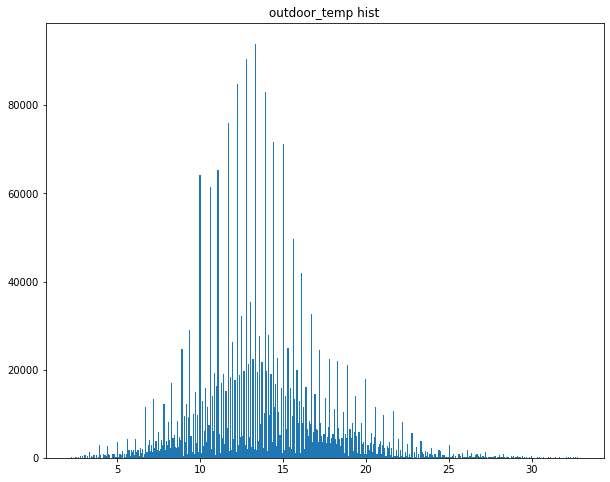

In [3]:
plt.figure(figsize=(10, 8))
plt.title("outdoor_temp hist")
bin_meta_outdoor_temp = plt.hist(df["outdoor_temp"], bins="fd")

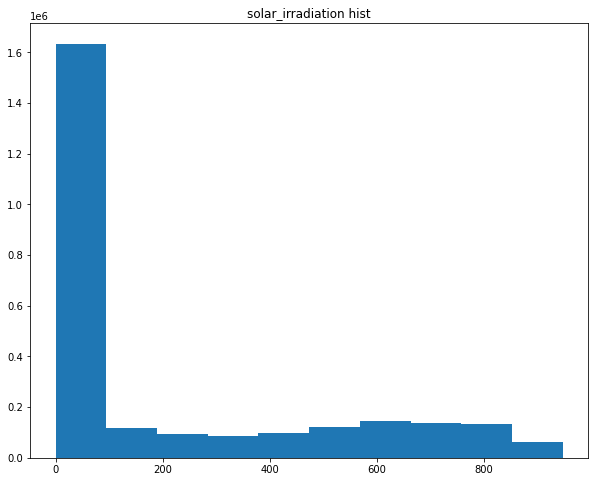

In [4]:
plt.figure(figsize=(10, 8))
plt.title("solar_irradiation hist")
bin_meta_solar = plt.hist(df["solar_irradiation"])

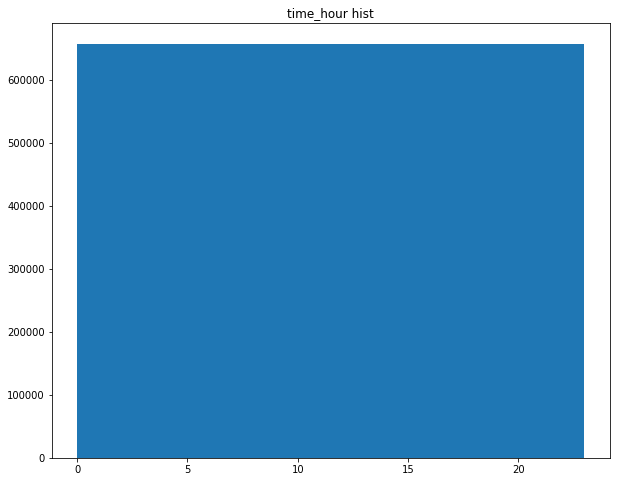

In [5]:
plt.figure(figsize=(10, 8))
plt.title("time_hour hist")
bin_meta_time = plt.hist(df["time_hour"], bins=4)

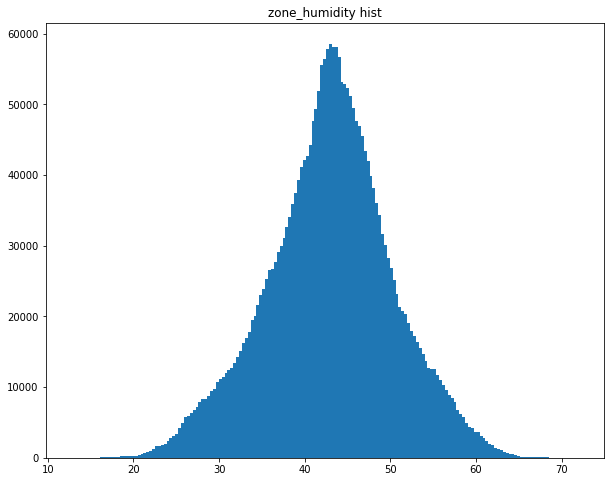

In [6]:
plt.figure(figsize=(10, 8))
plt.title("zone_humidity hist")
bin_meta_humid = plt.hist(df["zone_humidity"], bins=175)

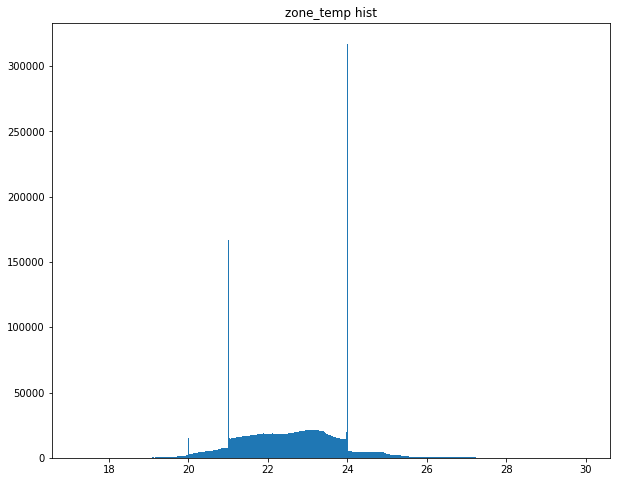

In [7]:
plt.figure(figsize=(10, 8))
plt.title("zone_temp hist")
bin_meta_temp = plt.hist(df["zone_temp"], bins='fd')

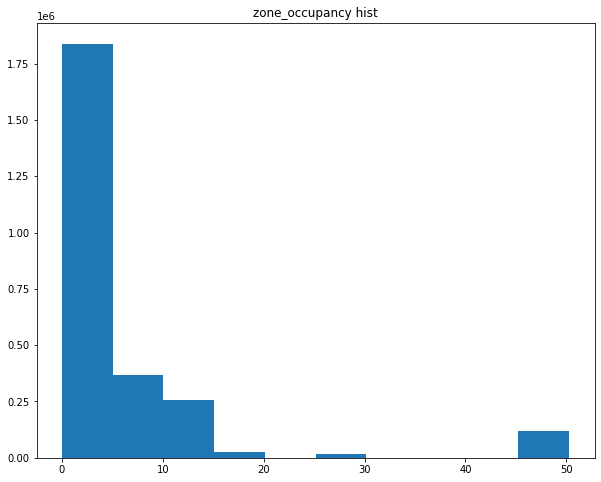

In [8]:
plt.figure(figsize=(10, 8))
plt.title("zone_occupancy hist")
bin_meta_occ = plt.hist(df["zone_occupancy"])

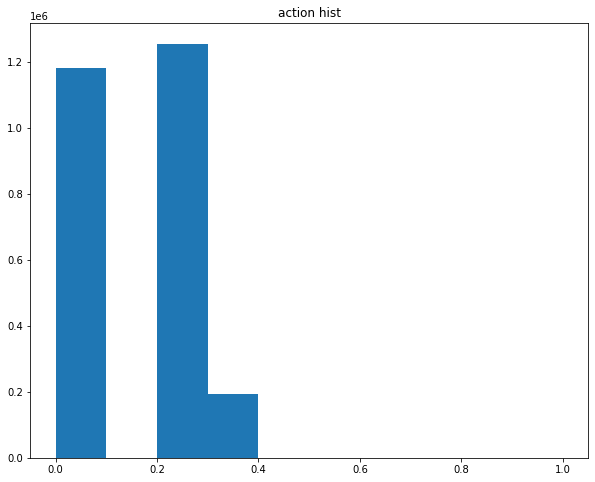

In [9]:
plt.figure(figsize=(10, 8))
plt.title("action hist")
start = 0.0
end = 1.0
width=0.1
ranges = []
for i in range(10):
    ranges.append((start+i*width, start + i*width + width))
bin_meta_action = plt.hist(df["action"], bins=10, range=(0, 1))

In [10]:
bin_meta_action

(array([1180835.,       0., 1254342.,  192808.,       0.,       0.,
              0.,       0.,       0.,       0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

## Action and State-Transition Probability

In [11]:
action_dims = len(df["action"].unique())

# action_prob = np.zeros((len(bin_meta_outdoor_temp[1]), len(bin_meta_solar[1]),
#                         len(bin_meta_time[1]), len(bin_meta_humid[1]),
#                         len(bin_meta_temp[1]), len(bin_meta_occ[1]), action_dims))
action_prob = {}
state_transition_prob = {}

df_dict = df.to_dict("records")  # Doing this is much faster than df.iterrows()

In [12]:
p_bar = tqdm(total=len(df))
for row in df_dict:
    outdoor_temp_bin = np.digitize(row["outdoor_temp"], bin_meta_outdoor_temp[1])-1
    solar_bin = np.digitize(row["solar_irradiation"], bin_meta_solar[1])-1
    time_bin = np.digitize(row["time_hour"], bin_meta_time[1])-1
    humidity_bin = np.digitize(row["zone_humidity"], bin_meta_humid[1])-1
    z_temp_bin = np.digitize(row["zone_temp"], bin_meta_temp[1])-1
    z_occ_bin = np.digitize(row["zone_occupancy"], bin_meta_occ[1])-1

    outdoor_temp_bin_tp1 = np.digitize(row["outdoor_temp_tp1"], bin_meta_outdoor_temp[1])-1
    solar_bin_tp1 = np.digitize(row["solar_irradiation_tp1"], bin_meta_solar[1])-1
    time_bin_tp1 = np.digitize(row["time_hour_tp1"], bin_meta_time[1])-1
    humidity_bin_tp1 = np.digitize(row["zone_humidity_tp1"], bin_meta_humid[1])-1
    z_temp_bin_tp1 = np.digitize(row["zone_temp_tp1"], bin_meta_temp[1])-1
    z_occ_bin_tp1 = np.digitize(row["zone_occupancy_tp1"], bin_meta_occ[1])-1
    
    s_t_str = f"{outdoor_temp_bin},{solar_bin},{time_bin},{humidity_bin},{z_temp_bin},{z_occ_bin}"
    s_tp1_str = f"{outdoor_temp_bin_tp1},{solar_bin_tp1},{time_bin_tp1},{humidity_bin_tp1},{z_temp_bin_tp1},{z_occ_bin_tp1}"
    
#     print(s_t_str)
    
    if s_t_str not in state_transition_prob:
        state_transition_prob[s_t_str] = {}
    if s_tp1_str not in state_transition_prob[s_t_str]:
        state_transition_prob[s_t_str][s_tp1_str] = 0
        
    state_transition_prob[s_t_str][s_tp1_str] += 1
    
    action_bin = np.digitize(row["action"], bin_meta_action[1])-1
    
    
    if s_t_str not in action_prob:
        action_prob[s_t_str] = {}
    if action_bin not in action_prob[s_t_str]:
        action_prob[s_t_str][action_bin] = 0
    
    action_prob[s_t_str][action_bin] += 1
#     action_prob[outdoor_temp_bin, solar_bin, time_bin,
#                 humidity_bin, z_temp_bin, z_occ_bin, action_bin] += 1
    p_bar.update(1)
action_prob["outdoor_temp_bins"] = bin_meta_outdoor_temp[1]
action_prob["solar_irradiation_bins"] = bin_meta_solar[1]
action_prob["time_hour_bins"] = bin_meta_time[1]
action_prob["zone_humidity_bins"] = bin_meta_humid[1]
action_prob["zone_temp_bins"] = bin_meta_temp[1]
action_prob["zone_occupancy_bins"] = bin_meta_occ[1]
action_prob["action_bins"] = bin_meta_action[1]
action_prob["total_count"] = len(df)
state_transition_prob["total_count"] = len(df)
p_bar.close()

  0%|          | 0/2627985 [00:00<?, ?it/s]

In [13]:
import pickle
with open("../data/rule_based_log_data/15zone_new/action_probs_all_data.pkl", "wb+") as f:
    pickle.dump(action_prob, f)

with open("../data/rule_based_log_data/15zone_new/state_trans_prob_all_data.pkl", "wb+") as f:
    pickle.dump(state_transition_prob, f)

In [16]:
action_prob

{'96,0,0,59,204,0': {0.0: 3},
 'outdoor_temp_bins': array([-23.        , -22.75433071, -22.50866142, -22.26299213,
        -22.01732283, -21.77165354, -21.52598425, -21.28031496,
        -21.03464567, -20.78897638, -20.54330709, -20.2976378 ,
        -20.0519685 , -19.80629921, -19.56062992, -19.31496063,
        -19.06929134, -18.82362205, -18.57795276, -18.33228346,
        -18.08661417, -17.84094488, -17.59527559, -17.3496063 ,
        -17.10393701, -16.85826772, -16.61259843, -16.36692913,
        -16.12125984, -15.87559055, -15.62992126, -15.38425197,
        -15.13858268, -14.89291339, -14.64724409, -14.4015748 ,
        -14.15590551, -13.91023622, -13.66456693, -13.41889764,
        -13.17322835, -12.92755906, -12.68188976, -12.43622047,
        -12.19055118, -11.94488189, -11.6992126 , -11.45354331,
        -11.20787402, -10.96220472, -10.71653543, -10.47086614,
        -10.22519685,  -9.97952756,  -9.73385827,  -9.48818898,
         -9.24251969,  -8.99685039,  -8.7511811 ,  -8